In [110]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import MinMaxScaler,StandardScaler,QuantileTransformer
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix, roc_curve, auc
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier 
from sklearn.svm import SVC
import optuna

# Data Preprocessing

Veri setimiz de kolon isimleri olmadığı için öncelikle veri setine kolon isimleri ekleyerek işe başlayalım.

Number of times pregnant:Pregnancies

Plasma glucose concentration a 2 hours in an oral glucose tolerance test : Glucose

Diastolic blood pressure (mm Hg). : BloodPressure

Triceps skinfold thickness (mm). : SkinThickness

2-Hour serum insulin (mu U/ml). : Insulin

Body mass index (weight in kg/(height in m)^2). : BMI

Diabetes pedigree function. : DPF

Age (years). : Age

Class variable (0 or 1). : ClassVariable

In [2]:
column_names = ["Pregnancies", "Glucose", "BloodPressure", "SkinThickness", 
                "Insulin", "BMI", "DPF","Age", "ClassVariable"]

In [3]:
data = pd.read_csv('./data/veri-seti.txt',names=column_names ,delimiter = "\t")

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Pregnancies    768 non-null    int64  
 1   Glucose        768 non-null    int64  
 2   BloodPressure  768 non-null    int64  
 3   SkinThickness  768 non-null    int64  
 4   Insulin        768 non-null    int64  
 5   BMI            768 non-null    float64
 6   DPF            768 non-null    float64
 7   Age            768 non-null    int64  
 8   ClassVariable  768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


datamız 768 satır ve 9 kolondan oluşuyor. datada ki değerlerin hepsi sayısal değerler. iki kolon da ise float değerler söz konusu.

In [5]:
data.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI    DPF  \
0            6      148             72             35        0  33.6  0.627   
1            1       85             66             29        0  26.6  0.351   
2            8      183             64              0        0  23.3  0.672   
3            1       89             66             23       94  28.1  0.167   
4            0      137             40             35      168  43.1  2.288   

   Age  ClassVariable  
0   50              1  
1   31              0  
2   32              1  
3   21              0  
4   33              1

data da hiç null değer var mı bir bakalım. bu arada ilk 5 veriyi yazdırınca göze çarpan ilk şey datanın bazı kolonlarında 0 verilerinin olduğu. mesela Insulin değerleri arasında 0 verisi var ve bunun olması imkansız. Muhtemelen datada kayıp veri var. buna da bakmamız gerekecek.

In [6]:
print(data.isnull().any())

Pregnancies      False
Glucose          False
BloodPressure    False
SkinThickness    False
Insulin          False
BMI              False
DPF              False
Age              False
ClassVariable    False
dtype: bool


data da hiç null veri yok. birde datanın min max ort ve std verilerine bakalım.

In [7]:
data.describe().T

count        mean         std     min       25%       50%  \
Pregnancies    768.0    3.845052    3.369578   0.000   1.00000    3.0000   
Glucose        768.0  120.894531   31.972618   0.000  99.00000  117.0000   
BloodPressure  768.0   69.105469   19.355807   0.000  62.00000   72.0000   
SkinThickness  768.0   20.536458   15.952218   0.000   0.00000   23.0000   
Insulin        768.0   79.799479  115.244002   0.000   0.00000   30.5000   
BMI            768.0   31.992578    7.884160   0.000  27.30000   32.0000   
DPF            768.0    0.471876    0.331329   0.078   0.24375    0.3725   
Age            768.0   33.240885   11.760232  21.000  24.00000   29.0000   
ClassVariable  768.0    0.348958    0.476951   0.000   0.00000    0.0000   

                     75%     max  
Pregnancies      6.00000   17.00  
Glucose        140.25000  199.00  
BloodPressure   80.00000  122.00  
SkinThickness   32.00000   99.00  
Insulin        127.25000  846.00  
BMI             36.60000   67.10  
DPF              0.62625    2.42  
Age             41.00000   81.00  
ClassVariable    1.00000    1.00

Fakat datanın describ'ine baktığımız da min değerleri 0 olan özellikler var.

Aşağıdaki özniteliklerde sıfır değerleri var ve bu öz nitelikleri için sıfır değeri bir anlam ifade etmez ve bu nedenle eksik değerlere işaret eder.

1.Glucose

2.BloodPressure

3.SkinThickness

4.Insulin

5.BMI

bu eksik değerleri NaN olarak değiştirelim ve kaç adet eksik değer varmış bir görelim. eğer eksik değer az ise datadan atabiliriz.

In [8]:
data_copy = data.copy(deep = True)
data_copy[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']] = (
    data_copy[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']]
    .replace(0, np.NaN)
)

print(data_copy.isnull().sum())

Pregnancies        0
Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
DPF                0
Age                0
ClassVariable      0
dtype: int64


In [9]:
# Veri setindeki kayıp değerlerin yüzdelik oranlarını hesaplayalım
missing_values_percent = (data_copy.isnull().sum() / len(data_copy)) * 100

# Grafik oluşturalım
plt.figure(figsize=(10, 6))
bars = missing_values_percent.plot(kind='bar', color='red')

# Çubukların üzerine yüzde değerlerini yazdıralım
for bar in bars.patches:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.3, f"{bar.get_height():.2f}%", ha='center', va='bottom')

plt.title('Kayıp Veri Yüzdesi')
plt.ylabel('%')
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

Kayıp Veriler :

Insulin       = 48.70%  - 374

SkinThickness = 29.56%  - 227

BloodPressure = 4.56%   -  35

BMI           = 1.43%   -  11

Glucose       = 0.65%   -   5

Eksik değerler çok fazla olduğu için datadan atmak veri kaybına neden olacak. 
Bu durumda eksik değerleri hangi yöntemle dolduracağımıza karar vermek için histogramına ve boxplotuna bakalım. 
Aykırı değerlerin çokça olduğu veri setlerinde median
Aykırı değerlerin çok olmadığı yada az olduğu veri setlerinde mean yöntemini kullanarak veriyi doldurabiliriz. 

Bir kişinin diyabete yakalanma olasılığını potansiyel olarak etkileyebilecek tüm değişkenlerin histogramlarını çizelim. 

İlk olarak veri çerçevesindeki tüm kişiler için değişkenlerin histogramlarına bakalım.
Daha sonra hasta bireyler için ayrı sağlıklı bireyler için ayrı ayrı histogramlara bakalım.
Bunun için positive ne negative sınıfları ayrı ayrı elde edelim öncelikle.

In [10]:
data_copy_positive = data[data_copy['ClassVariable']==1]
data_copy_positive.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI    DPF  \
0            6      148             72             35        0  33.6  0.627   
2            8      183             64              0        0  23.3  0.672   
4            0      137             40             35      168  43.1  2.288   
6            3       78             50             32       88  31.0  0.248   
8            2      197             70             45      543  30.5  0.158   

   Age  ClassVariable  
0   50              1  
2   32              1  
4   33              1  
6   26              1  
8   53              1

In [11]:
data_copy_negative = data[data_copy['ClassVariable']==0]
data_copy_negative.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI    DPF  \
1             1       85             66             29        0  26.6  0.351   
3             1       89             66             23       94  28.1  0.167   
5             5      116             74              0        0  25.6  0.201   
7            10      115              0              0        0  35.3  0.134   
10            4      110             92              0        0  37.6  0.191   

    Age  ClassVariable  
1    31              0  
3    21              0  
5    30              0  
7    29              0  
10   30              0

In [12]:
# tüm datanın histogramı
fig, ax = plt.subplots(4,2, figsize=(15,15))
sns.histplot(data_copy.Pregnancies, bins = 10, color = 'orange',kde=True, ax=ax[0,0]) 
sns.histplot(data_copy.Glucose, bins = 10, color = 'orange',kde=True, ax=ax[0,1]) 
sns.histplot(data_copy.BloodPressure, bins = 10, color = 'orange',kde=True, ax=ax[1,0]) 
sns.histplot(data_copy.SkinThickness, bins = 10, color = 'orange',kde=True, ax=ax[1,1]) 
sns.histplot(data_copy.Insulin, bins = 10, color = 'orange',kde=True, ax=ax[2,0])
sns.histplot(data_copy.BMI, bins = 10, color = 'orange',kde=True, ax=ax[2,1])
sns.histplot(data_copy.DPF, bins = 10, color = 'orange',kde=True, ax=ax[3,0]) 
sns.histplot(data_copy.Age, bins = 10,color = 'orange',kde=True, ax=ax[3,1]) 

<Axes: xlabel='Age', ylabel='Count'>

Şimdi, benzer şekilde, yalnızca veri çerçevesindeki diyabet testi negatif çıkan kişiler için yani sağlıklı kişiler için değişkenlerin histogramlarını çizelim.

<Axes: xlabel='Age', ylabel='Count'>

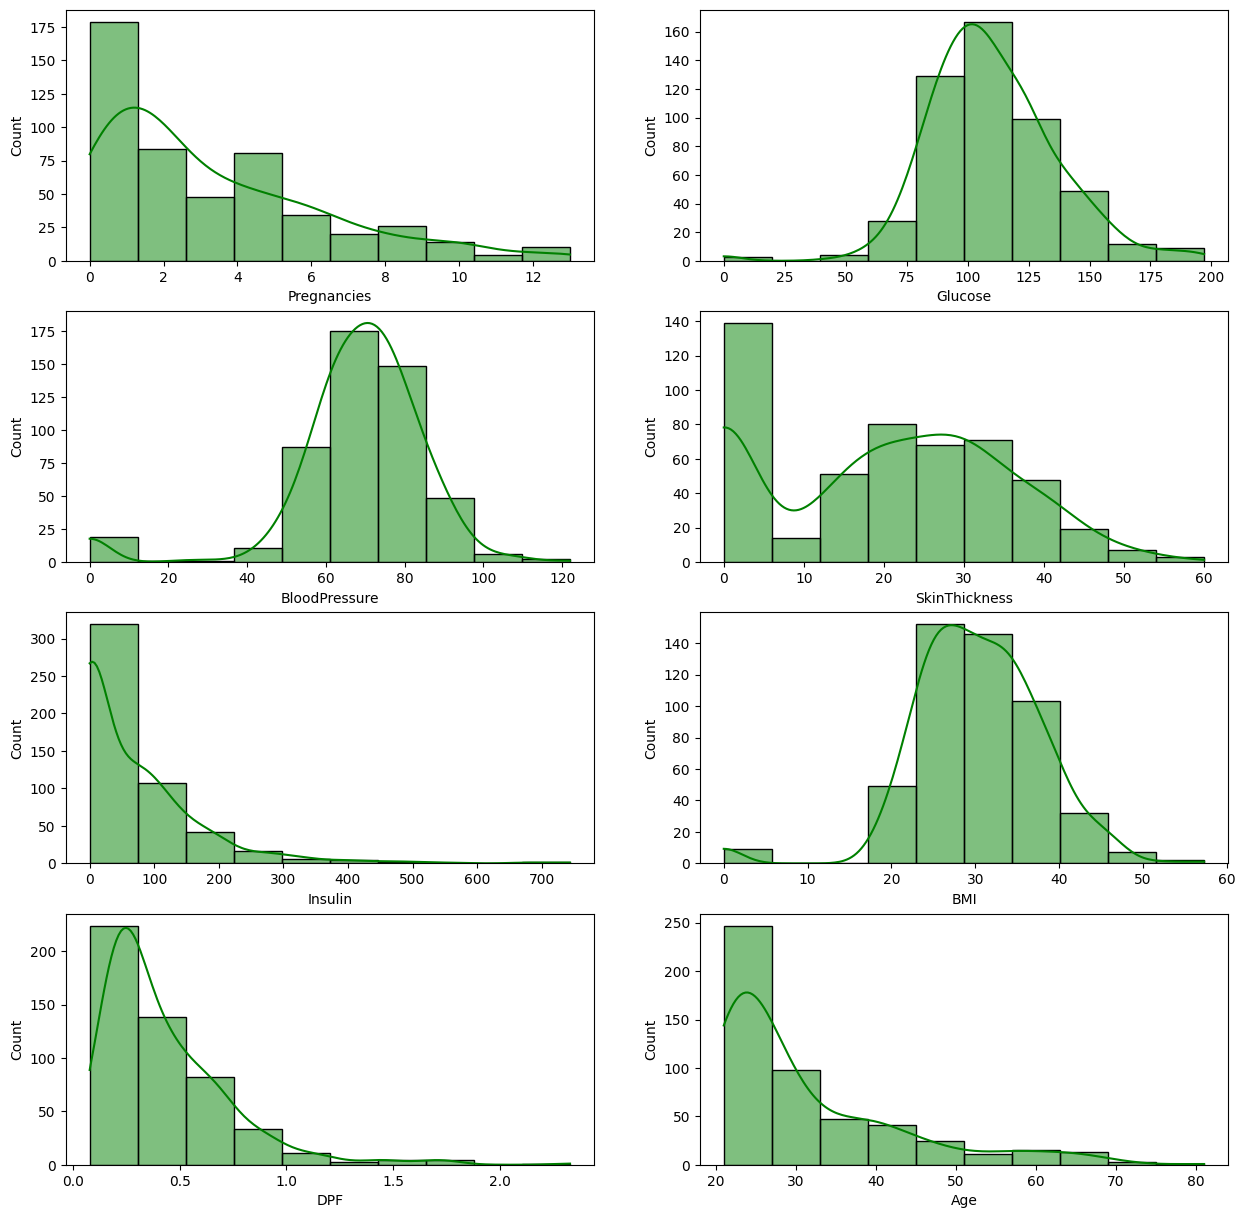

In [13]:
# sağlıklı kşilerin histogramı
fig, ax = plt.subplots(4,2, figsize=(15,15))
sns.histplot(data_copy_negative.Pregnancies, bins = 10, color = 'green',kde=True, ax=ax[0,0]) 
sns.histplot(data_copy_negative.Glucose, bins = 10, color = 'green',kde=True, ax=ax[0,1]) 
sns.histplot(data_copy_negative.BloodPressure, bins = 10, color = 'green',kde=True, ax=ax[1,0]) 
sns.histplot(data_copy_negative.SkinThickness, bins = 10, color = 'green',kde=True, ax=ax[1,1]) 
sns.histplot(data_copy_negative.Insulin, bins = 10, color = 'green',kde=True, ax=ax[2,0])
sns.histplot(data_copy_negative.BMI, bins = 10, color = 'green',kde=True, ax=ax[2,1])
sns.histplot(data_copy_negative.DPF, bins = 10, color = 'green',kde=True, ax=ax[3,0]) 
sns.histplot(data_copy_negative.Age, bins = 10,color = 'green',kde=True, ax=ax[3,1]) 

<Axes: xlabel='Age', ylabel='Count'>

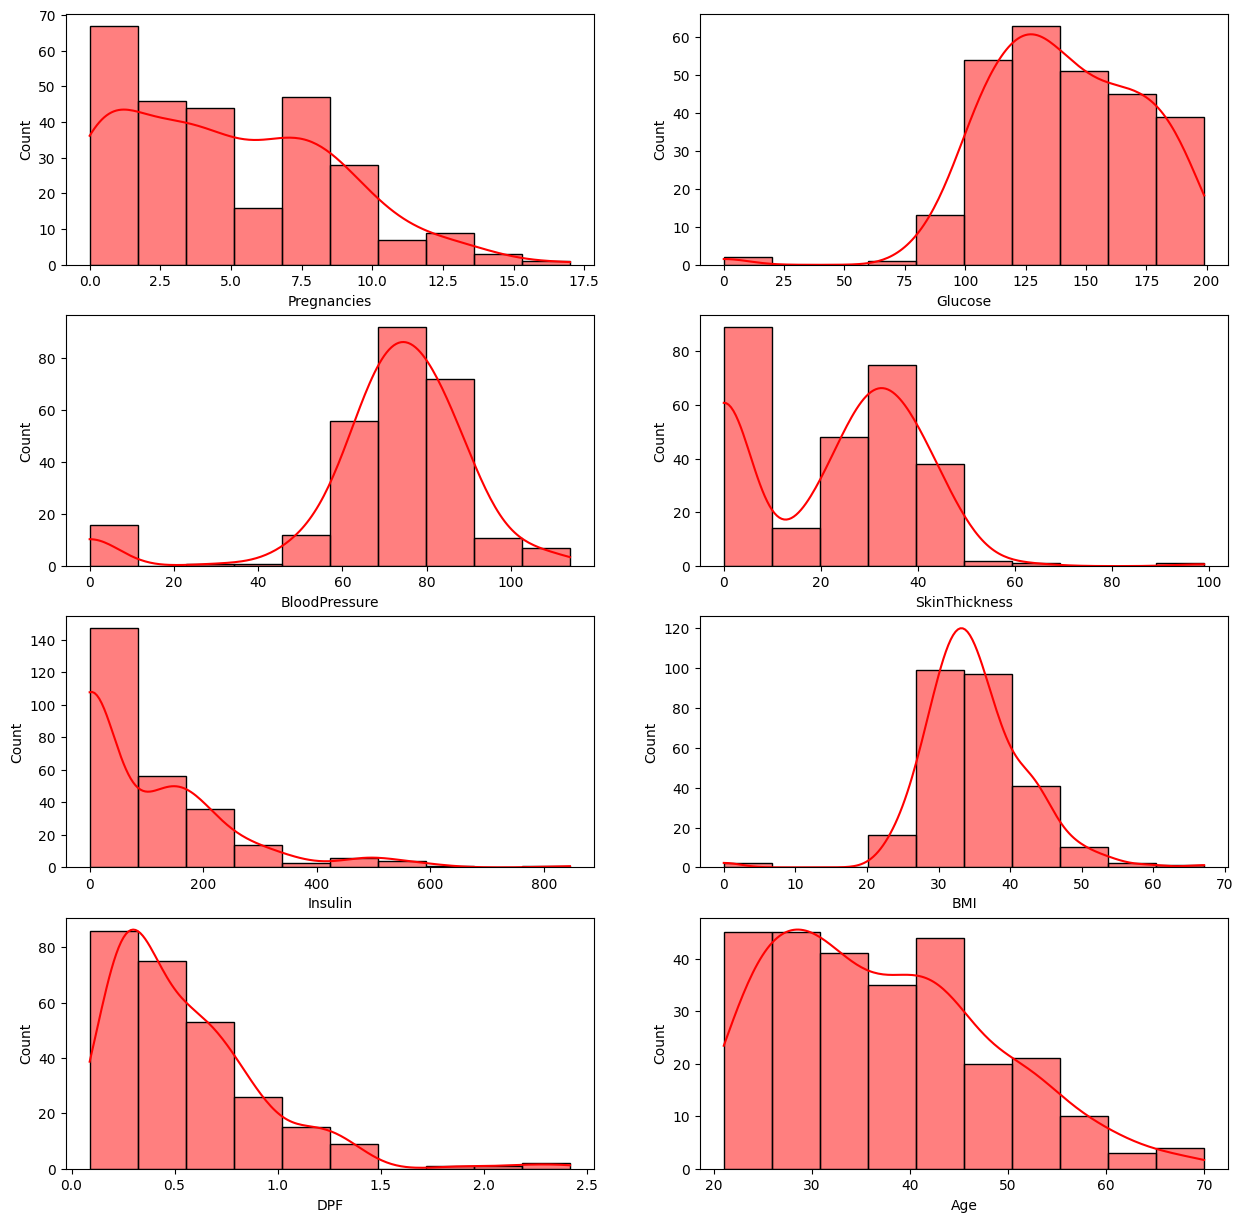

In [14]:
# hasta kşilerin histogramı
fig, ax = plt.subplots(4,2, figsize=(15,15))
sns.histplot(data_copy_positive.Pregnancies, bins = 10, color = 'red',kde=True, ax=ax[0,0]) 
sns.histplot(data_copy_positive.Glucose, bins = 10, color = 'red',kde=True, ax=ax[0,1]) 
sns.histplot(data_copy_positive.BloodPressure, bins = 10, color = 'red',kde=True, ax=ax[1,0]) 
sns.histplot(data_copy_positive.SkinThickness, bins = 10, color = 'red',kde=True, ax=ax[1,1]) 
sns.histplot(data_copy_positive.Insulin, bins = 10, color = 'red',kde=True, ax=ax[2,0])
sns.histplot(data_copy_positive.BMI, bins = 10, color = 'red',kde=True, ax=ax[2,1])
sns.histplot(data_copy_positive.DPF, bins = 10, color = 'red',kde=True, ax=ax[3,0]) 
sns.histplot(data_copy_positive.Age, bins = 10,color = 'red',kde=True, ax=ax[3,1]) 

Tüm eksik değerler NaN değeriyle kodlanmış oldu.
Datanın histogramına  bakıldı ve buradan hareketle bize eksik verilerin tamamlanması için bir fikir verdi.
Burada dikkat edilmesi gereken husus şudur; mean ile doldurulacak kayıp verileri ClassVariable değerlerinin her biri için ayrı ayrı hesaplamak lazım gerektiğidir. Çünkü sağlıklı bir kişinin Insulin değerleri ile hasta kişinin insulin değerleri aynı olmayacaktır. O bakımdan sağlıklı ve hasta veriler için ayrı ayrı mean hesaplanıp kayıp veriler buna dikkat edilerek doldurulması gerekir.
Bunun için bir fonksiyon yazalım ve her bir öznitelik için ortalamaları hasta ve sağlıklı bireyler için ayrı ayrı hesaplayarak kayıp verileri dolduralım.

In [15]:
def mean_target(var):   
    temp = data[data_copy[var].notnull()]
    temp = temp[[var, 'ClassVariable']].groupby(['ClassVariable'])[[var]].mean().reset_index()
    return temp

In [16]:
mean_target('Insulin')

ClassVariable     Insulin
0              0  130.287879
1              1  206.846154

Etiket değerlerimize göre insülinin mean değerleri gerçekten farklı! 
Sağlıklı bir kişi için 130.287879 iken diyabetik bir kişi için 206.846154 olmaktadır.Kayıp veriler doldurulurken bu husus göz önünde bulundurularak sağlıklı etiket değerlerinde ki kayıp veriler 130.287879 ile hasta etiket değerinde ki kayıp veriler 206.846154 ile değiştirilmesi gerekir. Bu kural diğer tüm kayıp veri barındıran öznitelikler için aynı şekilde yapılması gerekir. 

In [17]:
data_copy.loc[(data_copy['ClassVariable'] == 0 ) & (data_copy['Insulin'].isnull()), 'Insulin'] = 130.287879
data_copy.loc[(data_copy['ClassVariable'] == 1 ) & (data_copy['Insulin'].isnull()), 'Insulin'] = 206.846154

In [18]:
data.head(5)

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI    DPF  \
0            6      148             72             35        0  33.6  0.627   
1            1       85             66             29        0  26.6  0.351   
2            8      183             64              0        0  23.3  0.672   
3            1       89             66             23       94  28.1  0.167   
4            0      137             40             35      168  43.1  2.288   

   Age  ClassVariable  
0   50              1  
1   31              0  
2   32              1  
3   21              0  
4   33              1

In [19]:
data_copy.head(5)

Pregnancies  Glucose  BloodPressure  SkinThickness     Insulin   BMI  \
0            6    148.0           72.0           35.0  206.846154  33.6   
1            1     85.0           66.0           29.0  130.287879  26.6   
2            8    183.0           64.0            NaN  206.846154  23.3   
3            1     89.0           66.0           23.0   94.000000  28.1   
4            0    137.0           40.0           35.0  168.000000  43.1   

     DPF  Age  ClassVariable  
0  0.627   50              1  
1  0.351   31              0  
2  0.672   32              1  
3  0.167   21              0  
4  2.288   33              1

Dikkat edilecek olursa; manipüle edilmemiş data matrisinin ilk 3 insulin değeri 0 idi.data_copy matrisinde bu ilk 3 değer ilgili etiket değerine göre insulin özniteliğinin mean değeri ile değişmiş durumda. 

In [20]:
mean_target('SkinThickness')

ClassVariable  SkinThickness
0              0      27.235457
1              1      33.000000

In [21]:
data_copy.loc[(data_copy['ClassVariable'] == 0 ) & (data_copy['SkinThickness'].isnull()), 'SkinThickness'] = 27.235457
data_copy.loc[(data_copy['ClassVariable'] == 1 ) & (data_copy['SkinThickness'].isnull()), 'SkinThickness'] = 33.000000

In [22]:
mean_target('BloodPressure')

ClassVariable  BloodPressure
0              0      70.877339
1              1      75.321429

In [23]:
data_copy.loc[(data_copy['ClassVariable'] == 0 ) & (data_copy['BloodPressure'].isnull()), 'BloodPressure'] = 70.877339
data_copy.loc[(data_copy['ClassVariable'] == 1 ) & (data_copy['BloodPressure'].isnull()), 'BloodPressure'] = 75.321429

In [24]:
mean_target('BMI')

ClassVariable        BMI
0              0  30.859674
1              1  35.406767

In [25]:
data_copy.loc[(data_copy['ClassVariable'] == 0 ) & (data_copy['BMI'].isnull()), 'BMI'] = 30.859674
data_copy.loc[(data_copy['ClassVariable'] == 1 ) & (data_copy['BMI'].isnull()), 'BMI'] = 35.406767

In [26]:
mean_target('Glucose')

ClassVariable     Glucose
0              0  110.643863
1              1  142.319549

In [27]:
data_copy.loc[(data_copy['ClassVariable'] == 0 ) & (data_copy['Glucose'].isnull()), 'Glucose'] = 110.643863
data_copy.loc[(data_copy['ClassVariable'] == 1 ) & (data_copy['Glucose'].isnull()), 'Glucose'] = 142.319549

In [28]:
print(data_copy.isnull().sum())

Pregnancies      0
Glucose          0
BloodPressure    0
SkinThickness    0
Insulin          0
BMI              0
DPF              0
Age              0
ClassVariable    0
dtype: int64


In [29]:
data_copy.describe().T

count        mean        std     min        25%         50%  \
Pregnancies    768.0    3.845052   3.369578   0.000    1.00000    3.000000   
Glucose        768.0  121.697358  30.462008  44.000   99.75000  117.000000   
BloodPressure  768.0   72.428141  12.106044  24.000   64.00000   72.000000   
SkinThickness  768.0   29.247042   8.923908   7.000   25.00000   28.000000   
Insulin        768.0  157.003527  88.860914  14.000  121.50000  130.287879   
BMI            768.0   32.446420   6.878970  18.200   27.50000   32.050000   
DPF            768.0    0.471876   0.331329   0.078    0.24375    0.372500   
Age            768.0   33.240885  11.760232  21.000   24.00000   29.000000   
ClassVariable  768.0    0.348958   0.476951   0.000    0.00000    0.000000   

                      75%     max  
Pregnancies      6.000000   17.00  
Glucose        141.000000  199.00  
BloodPressure   80.000000  122.00  
SkinThickness   33.000000   99.00  
Insulin        206.846154  846.00  
BMI             36.600000   67.10  
DPF              0.626250    2.42  
Age             41.000000   81.00  
ClassVariable    1.000000    1.00

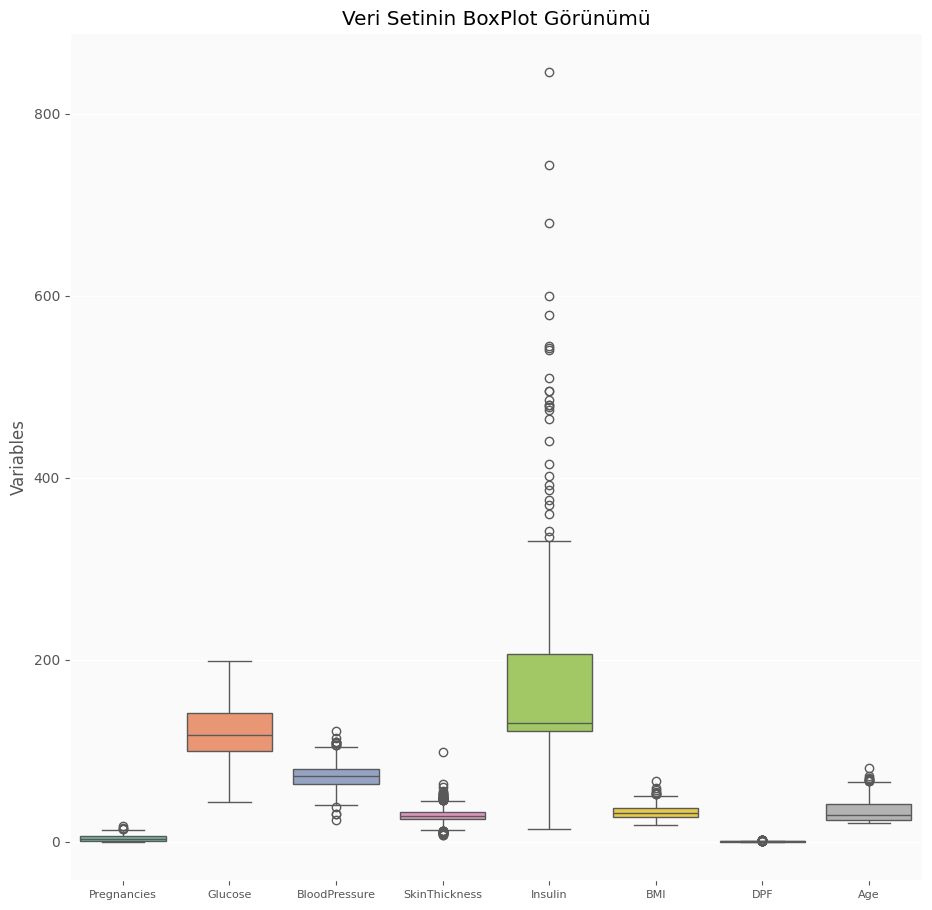

In [32]:
#box-plot çizdirme
plt.style.use('ggplot')

# 'ClassVariable' sütununu veri kümesinden kaldırma
data_no_class = data_copy.drop(columns=['ClassVariable'])

f, ax = plt.subplots(figsize=(11, 11))

ax.set_facecolor('#fafafa')
plt.ylabel('Variables')
plt.title("Veri Setinin BoxPlot Görünümü")
ax = sns.boxplot(data = data_no_class, orient = 'v', palette = 'Set2')
ax.tick_params(axis='x', labelsize=8)

# Winsorization İşlemi

Veri setinde, özellikle Insulin değerlerinde çok fazla aykırı değerler var. Bu aykırı değerleri baskılamanın çeşitli yöntemleri olmakla beraber, Winsorization, veri setindeki aykırı değerlerin etkilerini azaltmak veya ortadan kaldırmak için kullanılan bir yöntemdir. Bu yöntem, veri setindeki en yüksek ve en düşük değerleri sınırlı bir aralığa taşır ve bu sınırlar genellikle verinin yüzde x ve yüzde z dilimleridir. 

Örneğin, %90 Winsorization, verilerin en üst %5 ve en alt %5'inin değiştirilmesi anlamına gelir. Verilerin en üstteki %5'inin yerine 95. yüzdelik dilimdeki verinin değeri, en alttaki %5'in yerine ise 5. yüzdelik dilimdeki verinin değeri yerleştirilir. 

Şimdi Winsorization yapalım.

In [33]:
data_copy_w=data_copy.copy()
data_copy_w["Pregnancies"] = winsorize(data_copy_w["Pregnancies"],(0.01,0.01)) 
data_copy_w["Glucose"] = winsorize(data_copy_w["Glucose"],(0.01,0.01)) 
data_copy_w["BloodPressure"] = winsorize(data_copy_w["BloodPressure"],(0.02,0.02)) 
data_copy_w["SkinThickness"] = winsorize(data_copy_w["SkinThickness"],(0.05,0.05)) 
data_copy_w["Insulin"] = winsorize(data_copy_w["Insulin"],(0.05,0.05)) 
data_copy_w["BMI"] = winsorize(data_copy_w["BMI"],(0.02,0.02)) 
data_copy_w["DPF"] = winsorize(data_copy_w["DPF"],(0.05,0.05)) 
data_copy_w["Age"] = winsorize(data_copy_w["Age"],(0.02,0.02)) 

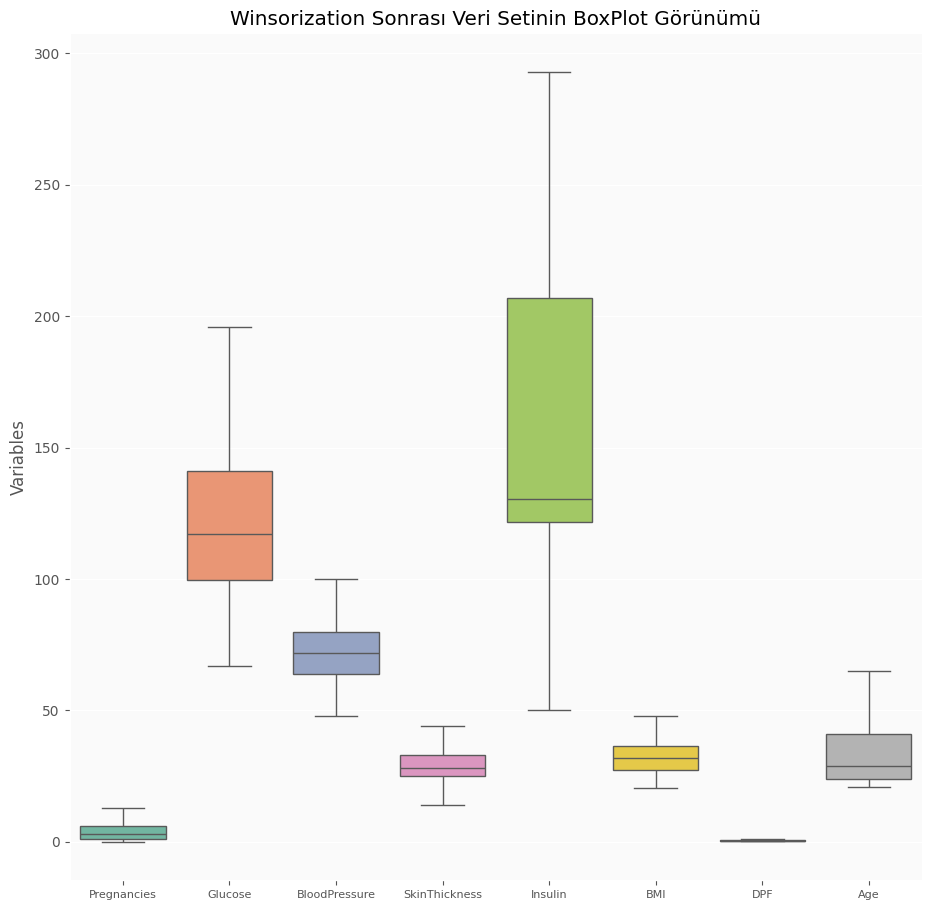

In [34]:
plt.style.use('ggplot') # Using ggplot2 style visuals 

# 'ClassVariable' sütununu veri kümesinden kaldırma
data_no_class_w = data_copy_w.drop(columns=['ClassVariable'])

f, ax = plt.subplots(figsize=(11, 11))

ax.set_facecolor('#fafafa')
plt.ylabel('Variables')
plt.title("Winsorization Sonrası Veri Setinin BoxPlot Görünümü")
ax = sns.boxplot(data = data_no_class_w, orient = 'v', palette = 'Set2')
ax.tick_params(axis='x', labelsize=8)


Yukarıda ki boxplotta görüleceği gibi Winsorization yöntemi ile Veri setinde ki aykırı değerler baskılanmış oldu.



Hedefimiz, bir kişinin diyabet hastası olup olmadığını tahmin etmek olduğu için bunu doğru bir şekilde yapabilmek 
adına tüm kayıp verileri düzeltmiş olduk. Veri çerçevesine baktığımızda, Insulin, SkinThickness, BloodPressure, BMI 
ve Glucose'da çok sayıda 0 değeri olduğunu gözlemlemiştik. Ancak bu değerlerden herhangi birinin bir kişi için sıfır 
olması mümkün değildi. Bunun nedeni, tüm bu sıfırların aslında eksik girişler olduğuydu. Bu nedenle, Insulin, 
SkinThickness, BloodPressure, BMI ve Glucose için 0 değerlerini kaldırdık ve bunları bu sütunların her biri için 
ortalama değerlerle değiştirdik.

Pregnancies (Hamilelik) sütunundaki 0 değerlerini değiştirmedik. 
Çünkü bu sadece kişinin hamile olmadığı anlamına gelir,kayıp veri değildir. 


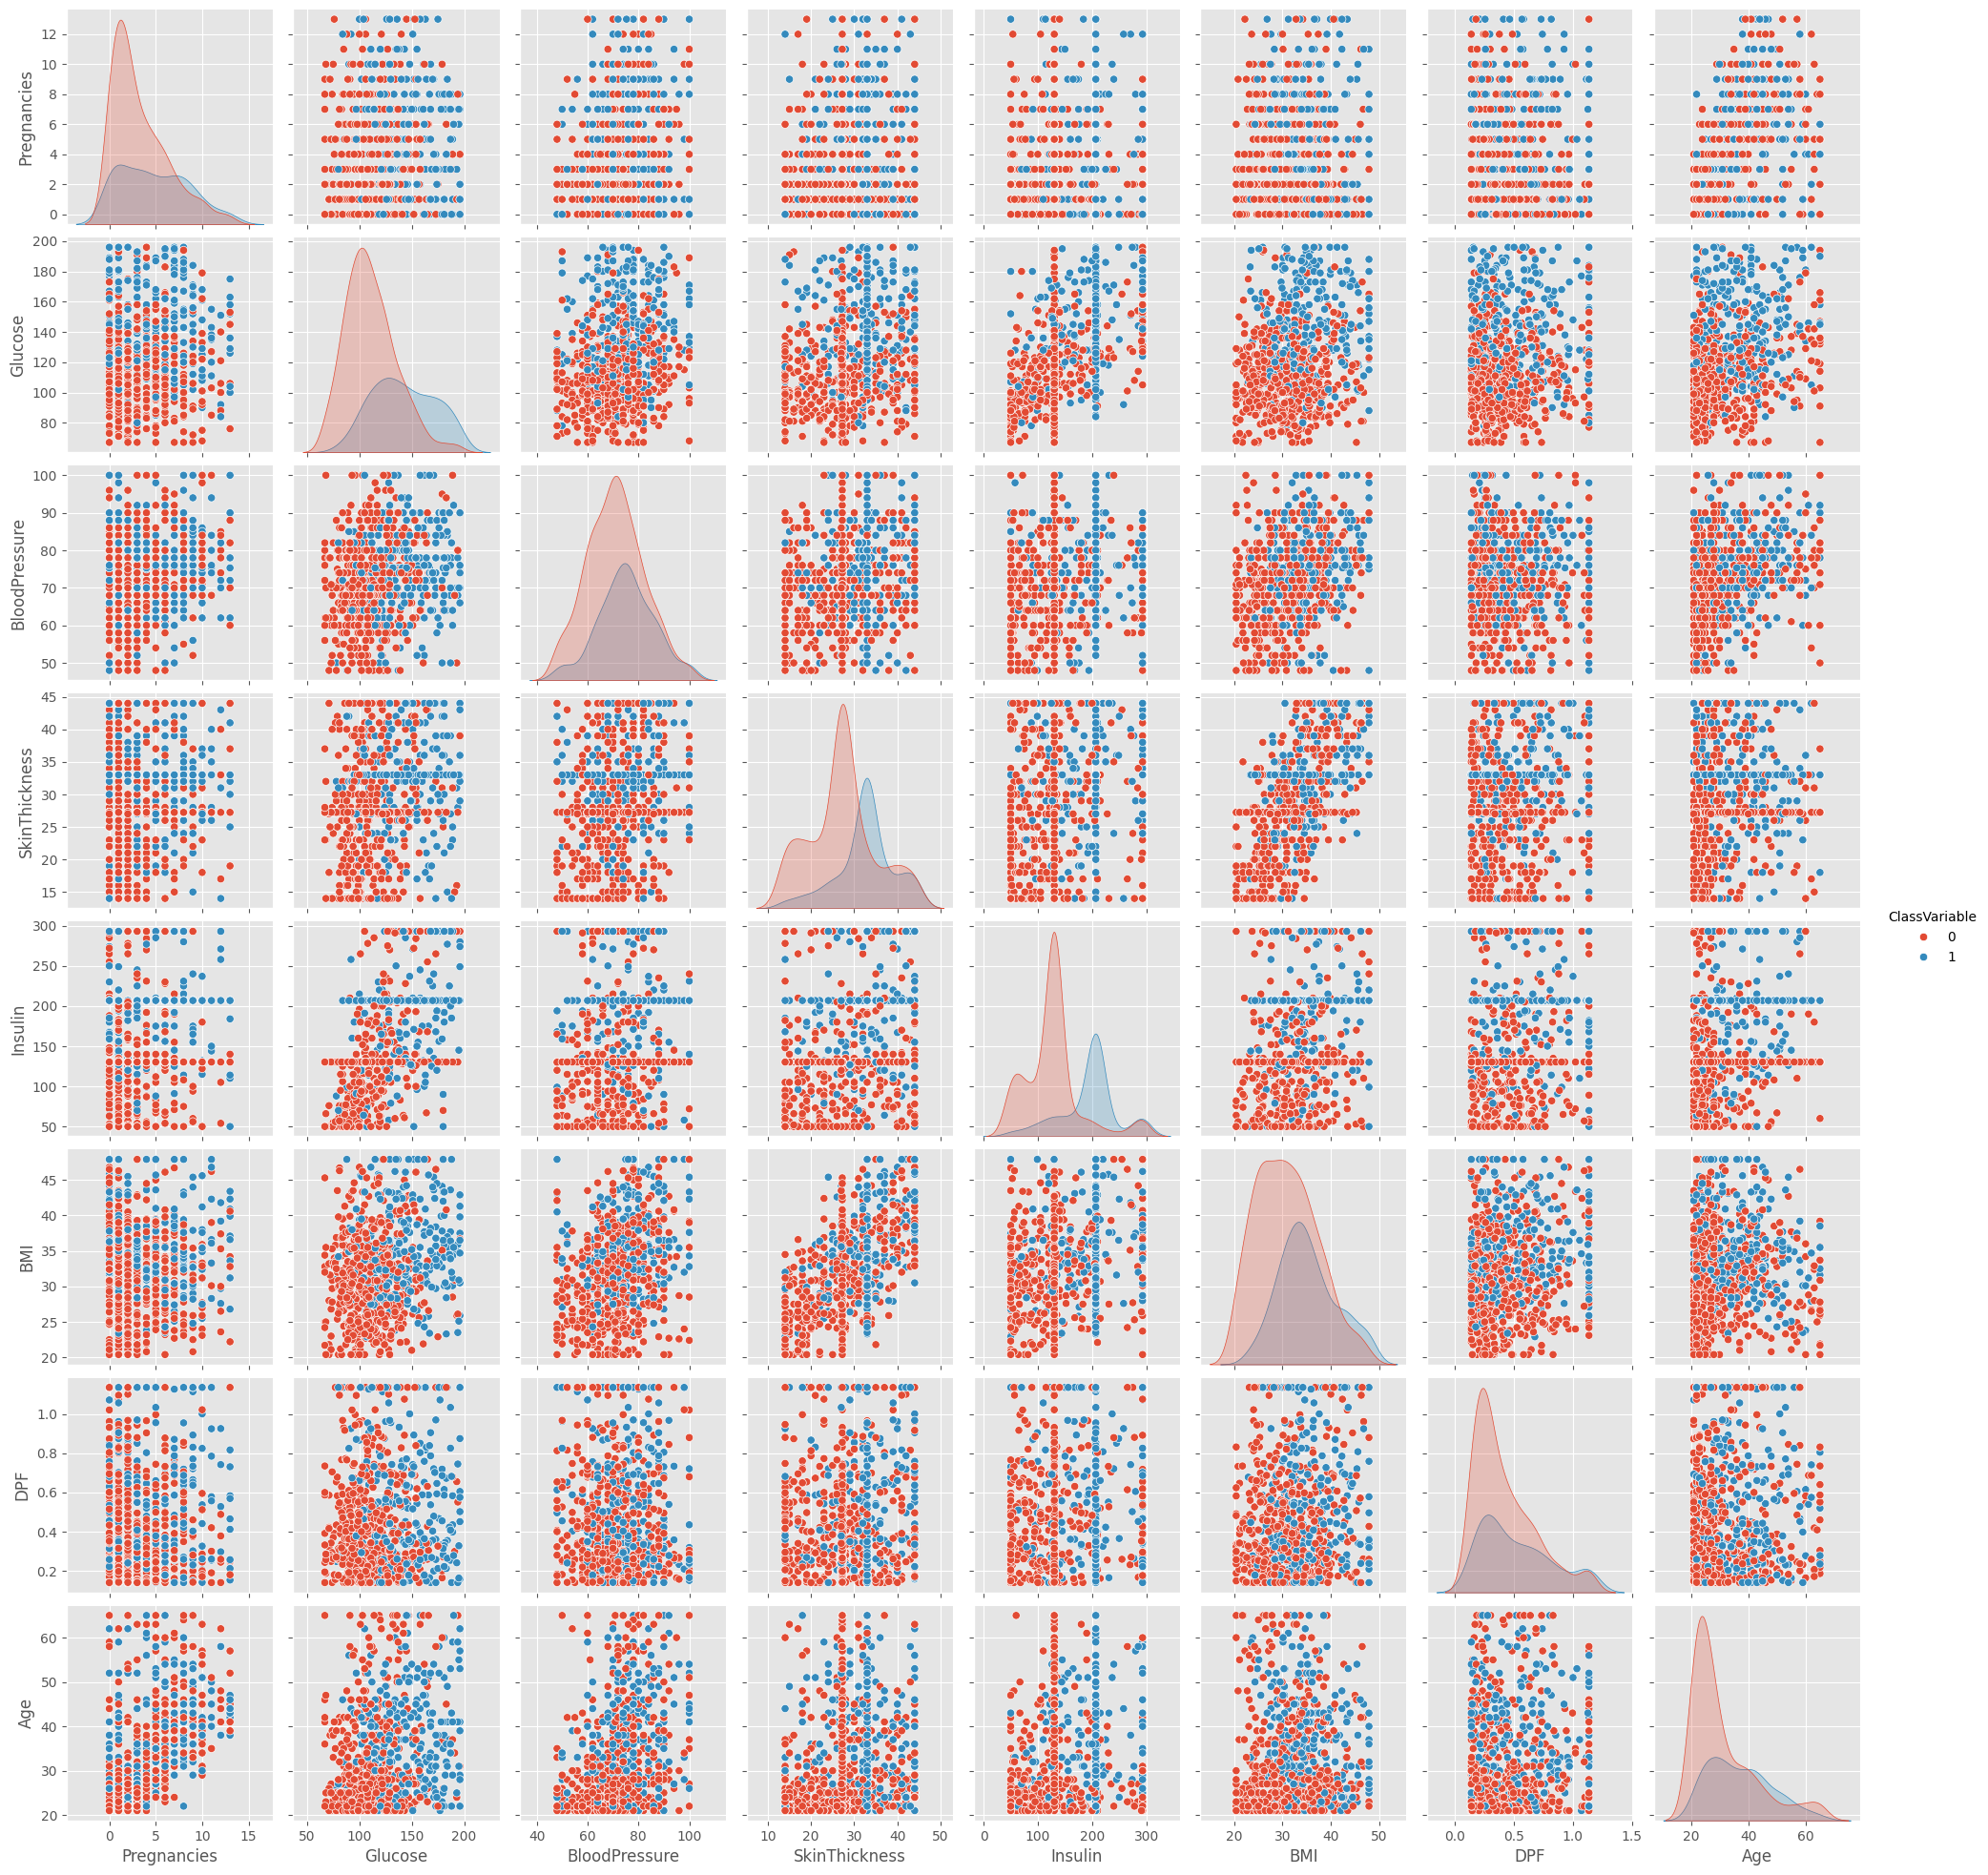

In [35]:
p=sns.pairplot(data_copy_w, hue = 'ClassVariable')

# Data Normalization



In [36]:
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(data_copy_w.drop(["ClassVariable"],axis = 1),),
        columns=['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DPF', 'Age'])

In [37]:
X_scaled.head()

Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0     0.649356  0.867411      -0.036362       0.760256  0.916581  0.187933   
1    -0.850059 -1.216191      -0.565245      -0.008463 -0.324394 -0.883293   
2     1.249122  2.024968      -0.741539       0.504016  0.916581 -1.388300   
3    -0.850059 -1.083899      -0.565245      -0.777181 -0.912604 -0.653745   
4    -1.149942  0.503607      -2.151893       0.760256  0.286902  1.641739   

        DPF       Age  
0  0.612465  1.455657  
1 -0.383935 -0.188379  
2  0.774922 -0.101851  
3 -1.048202 -1.053662  
4  2.450030 -0.015323

In [38]:
y = data_copy_w.ClassVariable

# SPLİT İşlemi

Veri setimizi split etmeden önce etiket verilerimizin dağılımına bakalım.

In [132]:
colors = ['gold', 'mediumturquoise']
labels = ['Sağlıklı','Hasta']
values = data_copy_w['ClassVariable'].value_counts()/data_copy_w['ClassVariable'].shape[0]

# Use `hole` to create a donut-like pie chart
fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.3)])
fig.update_traces(hoverinfo='label+percent', textinfo='percent', textfont_size=15,
                  marker=dict(colors=colors, line=dict(color='#000000', width=2)))
fig.update_layout(title_text="ClassVariable", width=400, height=400)
fig.show()

Yukarıdaki grafik verilerin dengesiz olduğunu göstermektedir. 

Sağlıklı bireylerin yüzdesi %65.1, diyabet hastası bireylerin yüzdesi ise %34.9

Bu durumda split işleminde bir detaya dikkat etmek gerekir.

Stratify parametresi, üretilen örneklemin değerlerinin oranının, stratify parametresine verilen 
değerlerin oranıyla aynı olmasını sağlayarak bir split yapar.

Örneğin, değişken y ikili kategorik bir değişkense ve değerleri 0 ve 1 ise 
ve sıfırların %25'i ve birlerin %75'i varsa, stratify=y, rastgele bölmenizin 
%25'inin 0 ve %75'inin 1 olduğundan emin olur.


In [40]:
#Ana Veri setini eğitim ve test verisi olarak ayırma
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42,stratify=y)

# Naive Bayes

In [130]:
#Naive Bayes sınıflandırıcısını eğitimi
naive_bayes_model = GaussianNB()
naive_bayes_model.fit(X_train, y_train)

GaussianNB()

In [51]:
#Test verisi üzerinde modelin performansını değerlendirme ve performans metriklerini hesaplama
naive_bayes_predictions = naive_bayes_model.predict(X_test)
naive_bayes_predictions_proba = naive_bayes_model.predict_proba(X_test)[:, 1]  # Sınıf 1'in olasılıklarını alıyoruz

In [47]:
# Sınıflandırma raporu oluşturma
classification_rep_NB = classification_report(y_test, naive_bayes_predictions)
print("Naive Bayes Sınıflandırma Raporu:")
print(classification_rep_NB)

Naive Bayes Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.87      0.83      0.85       150
           1       0.70      0.77      0.73        81

    accuracy                           0.81       231
   macro avg       0.79      0.80      0.79       231
weighted avg       0.81      0.81      0.81       231



In [48]:
# Hassasiyet (Sensitivity) ve Özgünlük (Specificity) hesaplama
conf_matrix_NB = confusion_matrix(y_test, naive_bayes_predictions)
tn_NB, fp_NB, fn_NB, tp_NB = conf_matrix_NB.ravel()
sensitivity_NB = tp_NB / (tp_NB + fn_NB)
specificity_NB = tn_NB / (tn_NB + fp_NB)
print("Naive Bayes Sensitivity:", sensitivity_NB)
print("Naive Bayes Specificity:", specificity_NB)

Naive Bayes Sensitivity: 0.7654320987654321
Naive Bayes Specificity: 0.8266666666666667


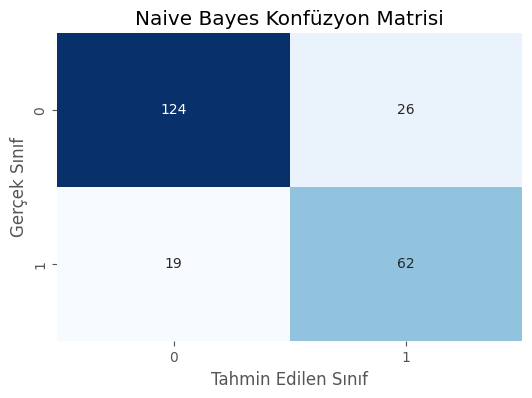

In [49]:
# Konfüzyon matrisi hesaplama
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_NB, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Tahmin Edilen Sınıf')
plt.ylabel('Gerçek Sınıf')
plt.title('Naive Bayes Konfüzyon Matrisi')
plt.show()

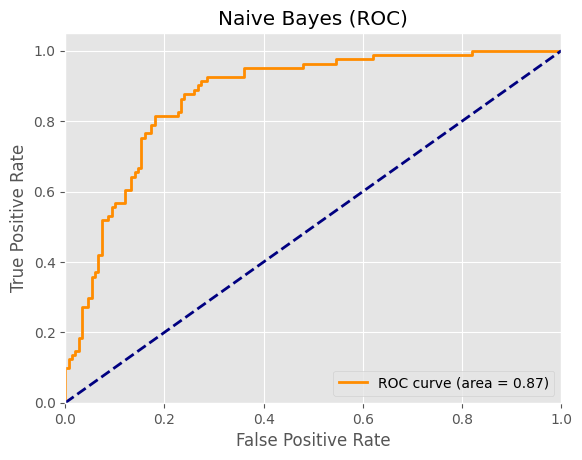

In [62]:
# ROC eğrisi ve AUC skoru
fpr_NB, tpr_NB, _ = roc_curve(y_test, naive_bayes_predictions_proba)
roc_auc_NB = auc(fpr_NB, tpr_NB)

# ROC eğrisini çizme
plt.figure()
plt.plot(fpr_NB, tpr_NB, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_NB:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Naive Bayes (ROC)')
plt.legend(loc='lower right')
plt.show()

# kNN

In [54]:
# k-NN modelini oluşturma ve eğitme
error = []

for i in range(1, 40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error.append(np.mean(pred_i != y_test))

In [55]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 40), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

Text(0, 0.5, 'Mean Error')

In [56]:
# En düşük hata oranını ve bu oranı veren K değerini bulalım
min_error = min(error)
best_k = error.index(min_error) + 1

print(f'En düşük hata oranı: {min_error}')
print(f'En iyi K değeri: {best_k}')

En düşük hata oranı: 0.15151515151515152
En iyi K değeri: 7


In [129]:
# En iyi K değeri ile k-NN modelini oluşturma ve eğitme
best_k = 7
knn_best = KNeighborsClassifier(n_neighbors=best_k)
knn_best.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=7)

In [58]:
# Test seti üzerinde tahminlerde bulunma
knn_prediction = knn_best.predict(X_test)
knn_prediction_proba = knn_best.predict_proba(X_test)[:, 1]  # Sınıf 1'in olasılıklarını alıyoruz

In [59]:
# Sınıflandırma raporu oluşturma
classification_rep_knn = classification_report(y_test, knn_prediction)
print("kNN Sınıflandırma Raporu:")
print(classification_rep_knn)

kNN Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.87      0.90      0.89       150
           1       0.80      0.75      0.78        81

    accuracy                           0.85       231
   macro avg       0.84      0.83      0.83       231
weighted avg       0.85      0.85      0.85       231



In [60]:
# Hassasiyet (Sensitivity) ve Özgünlük (Specificity) hesaplama
conf_matrix_knn = confusion_matrix(y_test, knn_prediction)
tn_knn, fp_knn, fn_knn, tp_knn = conf_matrix_knn.ravel()
sensitivity_knn = tp_knn / (tp_knn + fn_knn)
specificity_knn = tn_knn / (tn_knn + fp_knn)
print("kNN Sensitivity:", sensitivity_knn)
print("kNN Specificity:", specificity_knn)

kNN Sensitivity: 0.7530864197530864
kNN Specificity: 0.9


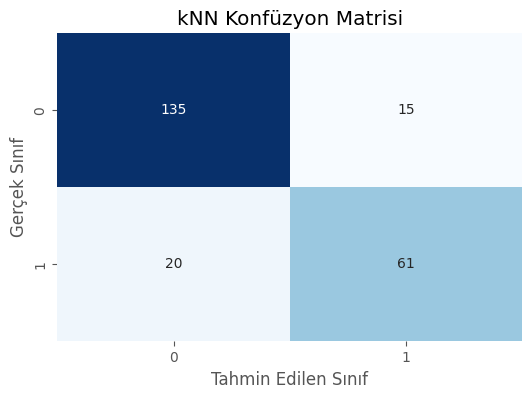

In [68]:
# Konfüzyon matrisi hesaplama
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_knn, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Tahmin Edilen Sınıf')
plt.ylabel('Gerçek Sınıf')
plt.title('kNN Konfüzyon Matrisi')
plt.show()

In [67]:
# ROC eğrisi ve AUC skoru
fpr_knn, tpr_knn, _ = roc_curve(y_test, knn_prediction_proba)
roc_auc_knn = auc(fpr_knn, tpr_knn)

# ROC eğrisini çizme
plt.figure()
plt.plot(fpr_knn, tpr_knn, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_knn:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('kNN (ROC)')
plt.legend(loc='lower right')
plt.show()

# MLP

In [128]:
# MLP modelini oluşturma ve eğitme
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, alpha=0.0001, solver='adam', random_state=42, learning_rate_init=0.001, early_stopping=True)
mlp.fit(X_train, y_train)

MLPClassifier(early_stopping=True, max_iter=1000, random_state=42)

In [101]:
# Test seti üzerinde tahminlerde bulunma
mlp_prediction = mlp.predict(X_test)
mlp_prediction_proba = mlp.predict_proba(X_test)[:, 1]  # Sınıf 1'in olasılıklarını alıyoruz

In [102]:
# Sınıflandırma raporu oluşturma
classification_rep_mlp = classification_report(y_test, mlp_prediction)
print("MLP Sınıflandırma Raporu:")
print(classification_rep_mlp)

MLP Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.75      0.92      0.83       150
           1       0.75      0.44      0.56        81

    accuracy                           0.75       231
   macro avg       0.75      0.68      0.69       231
weighted avg       0.75      0.75      0.73       231



In [103]:
# Hassasiyet (Sensitivity) ve Özgünlük (Specificity) hesaplama
conf_matrix_mlp = confusion_matrix(y_test, mlp_prediction)
tn_mlp, fp_mlp, fn_mlp, tp_mlp = conf_matrix_mlp.ravel()
sensitivity_mlp = tp_mlp / (tp_mlp + fn_mlp)
specificity_mlp = tn_mlp / (tn_mlp + fp_mlp)
print("MLP Sensitivity:", sensitivity_mlp)
print("MLP Specificity:", specificity_mlp)

MLP Sensitivity: 0.4444444444444444
MLP Specificity: 0.92


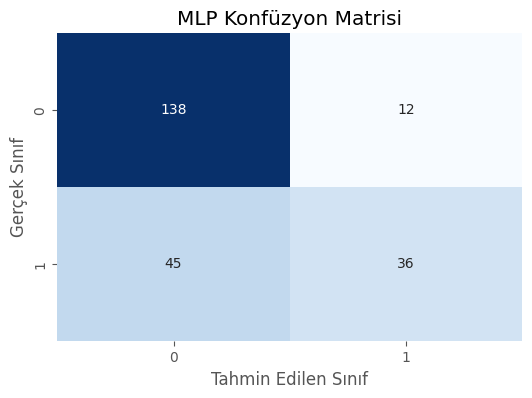

In [104]:
# Konfüzyon matrisi hesaplama
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_mlp, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Tahmin Edilen Sınıf')
plt.ylabel('Gerçek Sınıf')
plt.title('MLP Konfüzyon Matrisi')
plt.show()

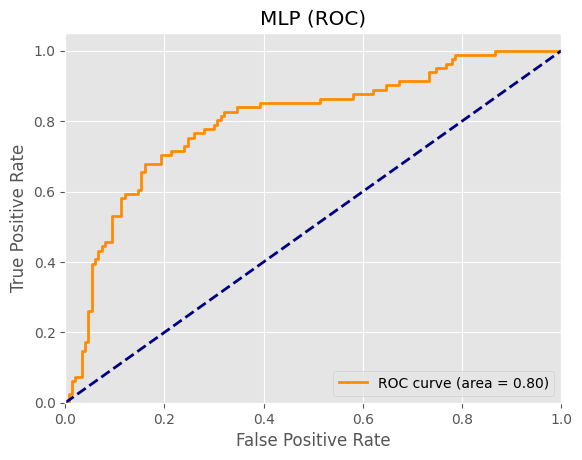

In [105]:
# ROC eğrisi ve AUC skoru
fpr_mlp, tpr_mlp, _ = roc_curve(y_test, mlp_prediction_proba)
roc_auc_mlp = auc(fpr_mlp, tpr_mlp)

# ROC eğrisini çizme
plt.figure()
plt.plot(fpr_mlp, tpr_mlp, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_mlp:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('MLP (ROC)')
plt.legend(loc='lower right')
plt.show()

## Hiperparametre Optimizasyonu Yaparak Daha İyi Sonuçlar Elde Etmeye Çalışalım

In [92]:
def objective(trial):
    # Hiperparametreler için arama alanı
    hidden_layer_sizes = trial.suggest_categorical('hidden_layer_sizes', [(50,), (100,), (50, 50), (100, 50)])
    activation = trial.suggest_categorical('activation', ['tanh', 'relu'])
    solver = trial.suggest_categorical('solver', ['sgd', 'adam'])
    alpha = trial.suggest_float('alpha', 1e-5, 1e-3, log=True)
    learning_rate_init = trial.suggest_float('learning_rate_init', 1e-4, 1e-2, log=True)
    
    # MLPClassifier'ı oluşturma
    mlp = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, activation=activation, solver=solver, alpha=alpha, learning_rate_init=learning_rate_init, max_iter=1000, random_state=42, early_stopping=True)
    mlp.fit(X_train, y_train)
    
    # Test seti üzerinde tahminlerde bulunma
    y_pred = mlp.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    return accuracy

In [95]:
# Optuna çalışması
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2024-06-09 19:23:47,630] A new study created in memory with name: no-name-d3a7e1d2-4268-4b5a-9384-13760622c668
C:\Users\cuneyt.bayrak\AppData\Local\anaconda3\envs\keras_env\Lib\site-packages\optuna\distributions.py:524: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.

C:\Users\cuneyt.bayrak\AppData\Local\anaconda3\envs\keras_env\Lib\site-packages\optuna\distributions.py:524: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.

C:\Users\cuneyt.bayrak\AppData\Local\anaconda3\envs\keras_env\Lib\site-packages\optuna\distributions.py:524: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.

C:\Users\cuneyt.bayrak\AppData\Local\an

In [96]:
# En iyi hiperparametreleri yazdırma
print('Best hyperparameters: ', study.best_params)

Best hyperparameters:  {'hidden_layer_sizes': (100, 50), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.00038525672449642065, 'learning_rate_init': 0.009668761085001898}


In [127]:
# MLP modelini en iyi parametrelere göre yeniden oluşturma ve eğitme
mlp_best = MLPClassifier(hidden_layer_sizes=(100,50), max_iter=1000,activation='relu' ,alpha=0.00038525672449642065, solver='adam', random_state=42, learning_rate_init=0.009668761085001898, early_stopping=True)
mlp_best.fit(X_train, y_train)

MLPClassifier(alpha=0.00038525672449642065, early_stopping=True,
              hidden_layer_sizes=(100, 50),
              learning_rate_init=0.009668761085001898, max_iter=1000,
              random_state=42)

In [98]:
# Test seti üzerinde tahminlerde bulunma
mlp_prediction_best = mlp_best.predict(X_test)
mlp_prediction_proba_best = mlp_best.predict_proba(X_test)[:, 1]  # Sınıf 1'in olasılıklarını alıyoruz

In [99]:
# Sınıflandırma raporu oluşturma
classification_rep_mlp_best = classification_report(y_test, mlp_prediction_best)
print("MLP_best Sınıflandırma Raporu:")
print(classification_rep_mlp_best)

MLP_best Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.90      0.86      0.88       150
           1       0.76      0.81      0.79        81

    accuracy                           0.84       231
   macro avg       0.83      0.84      0.83       231
weighted avg       0.85      0.84      0.85       231



In [106]:
# Hassasiyet (Sensitivity) ve Özgünlük (Specificity) hesaplama
conf_matrix_mlp_best = confusion_matrix(y_test, mlp_prediction_best)
tn_mlp_best, fp_mlp_best, fn_mlp_best, tp_mlp_best = conf_matrix_mlp_best.ravel()
sensitivity_mlp_best = tp_mlp_best / (tp_mlp_best + fn_mlp_best)
specificity_mlp_best = tn_mlp_best / (tn_mlp_best + fp_mlp_best)
print("MLP_best Sensitivity:", sensitivity_mlp_best)
print("MLP_best Specificity:", specificity_mlp_best)

MLP_best Sensitivity: 0.8148148148148148
MLP_best Specificity: 0.86


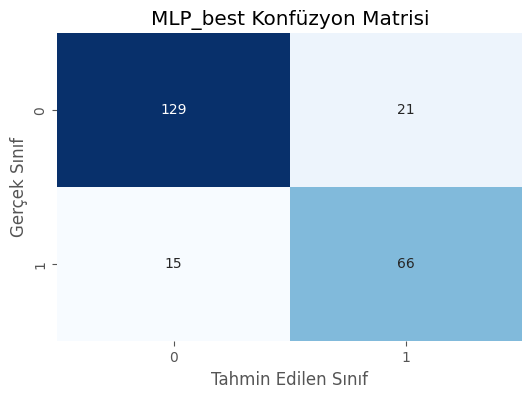

In [107]:
# Konfüzyon matrisi hesaplama
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_mlp_best, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Tahmin Edilen Sınıf')
plt.ylabel('Gerçek Sınıf')
plt.title('MLP_best Konfüzyon Matrisi')
plt.show()

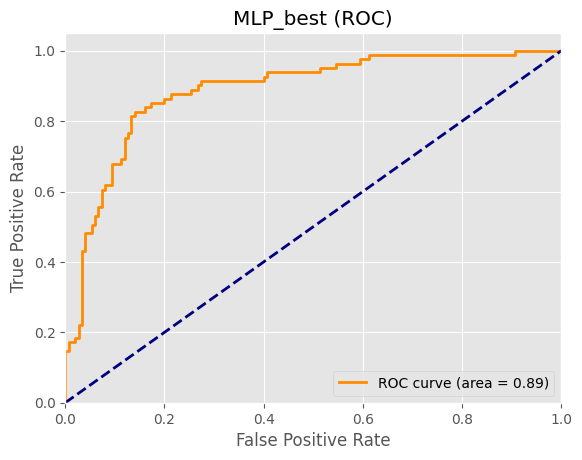

In [108]:
# ROC eğrisi ve AUC skoru
fpr_mlp_best, tpr_mlp_best, _ = roc_curve(y_test, mlp_prediction_proba_best)
roc_auc_mlp_best = auc(fpr_mlp_best, tpr_mlp_best)

# ROC eğrisini çizme
plt.figure()
plt.plot(fpr_mlp_best, tpr_mlp_best, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_mlp_best:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('MLP_best (ROC)')
plt.legend(loc='lower right')
plt.show()

# SVM-Linear

In [126]:
# SVM modelini oluşturma ve eğitme
svm_ln = SVC(kernel='linear', probability=True, random_state=42)
svm_ln.fit(X_train, y_train)

SVC(kernel='linear', probability=True, random_state=42)

In [112]:
# Test seti üzerinde tahminlerde bulunma
y_pred_svm_ln = svm_ln.predict(X_test)
y_pred_proba_svm_ln = svm_ln.predict_proba(X_test)[:, 1]  # Sınıf 1'in olasılıklarını alıyoruz

In [113]:
# Sınıflandırma raporu oluşturma
classification_rep_svm_ln = classification_report(y_test, y_pred_svm_ln)
print("SVM_ln Sınıflandırma Raporu:")
print(classification_rep_svm_ln)

SVM_ln Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.91      0.87      0.89       150
           1       0.77      0.84      0.80        81

    accuracy                           0.86       231
   macro avg       0.84      0.85      0.85       231
weighted avg       0.86      0.86      0.86       231



In [114]:
# Hassasiyet (Sensitivity) ve Özgünlük (Specificity) hesaplama
conf_matrix_svm_ln = confusion_matrix(y_test, y_pred_svm_ln)
tn_svm_ln, fp_svm_ln, fn_svm_ln, tp_svm_ln = conf_matrix_svm_ln.ravel()
sensitivity_svm_ln = tp_svm_ln / (tp_svm_ln + fn_svm_ln)
specificity_svm_ln = tn_svm_ln / (tn_svm_ln + fp_svm_ln)
print("SVM_ln Sensitivity:", sensitivity_svm_ln)
print("SVM_ln Specificity:", specificity_svm_ln)

SVM_ln Sensitivity: 0.8395061728395061
SVM_ln Specificity: 0.8666666666666667


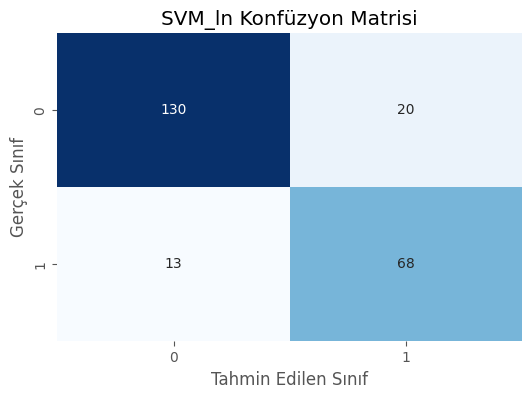

In [115]:
# Konfüzyon matrisi hesaplama
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_svm_ln, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Tahmin Edilen Sınıf')
plt.ylabel('Gerçek Sınıf')
plt.title('SVM_ln Konfüzyon Matrisi')
plt.show()

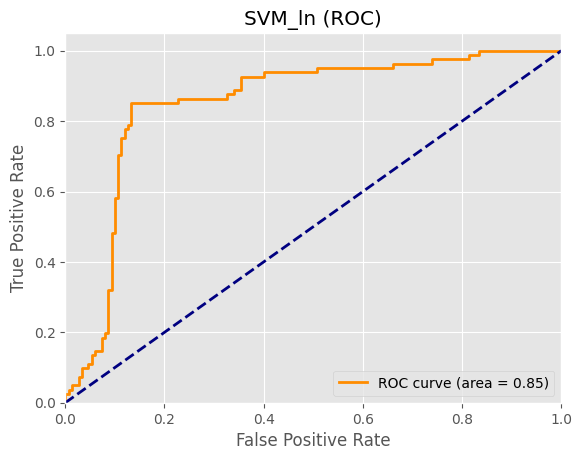

In [116]:
# ROC eğrisi ve AUC skoru
fpr_svm_ln, tpr_svm_ln, _ = roc_curve(y_test, y_pred_proba_svm_ln)
roc_auc_svm_ln = auc(fpr_svm_ln, tpr_svm_ln)

# ROC eğrisini çizme
plt.figure()
plt.plot(fpr_svm_ln, tpr_svm_ln, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_svm_ln:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM_ln (ROC)')
plt.legend(loc='lower right')
plt.show()

# SVM-RBF

In [125]:
# SVM modelini oluşturma ve eğitme
svm_rbf = SVC(kernel='rbf', probability=True, random_state=42)
svm_rbf.fit(X_train, y_train)

SVC(probability=True, random_state=42)

In [119]:
# Test seti üzerinde tahminlerde bulunma
y_pred_svm_rbf = svm_rbf.predict(X_test)
y_pred_proba_svm_rbf = svm_rbf.predict_proba(X_test)[:, 1]  # Sınıf 1'in olasılıklarını alıyoruz

In [120]:
# Sınıflandırma raporu oluşturma
classification_rep_svm_rbf = classification_report(y_test, y_pred_svm_rbf)
print("SVM_rbf Sınıflandırma Raporu:")
print(classification_rep_svm_rbf)

SVM_rbf Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.89      0.88      0.88       150
           1       0.78      0.79      0.79        81

    accuracy                           0.85       231
   macro avg       0.83      0.84      0.83       231
weighted avg       0.85      0.85      0.85       231



In [121]:
# Hassasiyet (Sensitivity) ve Özgünlük (Specificity) hesaplama
conf_matrix_svm_rbf = confusion_matrix(y_test, y_pred_svm_rbf)
tn_svm_rbf, fp_svm_rbf, fn_svm_rbf, tp_svm_rbf = conf_matrix_svm_rbf.ravel()
sensitivity_svm_rbf = tp_svm_rbf / (tp_svm_rbf + fn_svm_rbf)
specificity_svm_rbf = tn_svm_rbf / (tn_svm_rbf + fp_svm_rbf)
print("SVM_rbf Sensitivity:", sensitivity_svm_rbf)
print("SVM_rbf Specificity:", specificity_svm_rbf)

SVM_rbf Sensitivity: 0.7901234567901234
SVM_rbf Specificity: 0.88


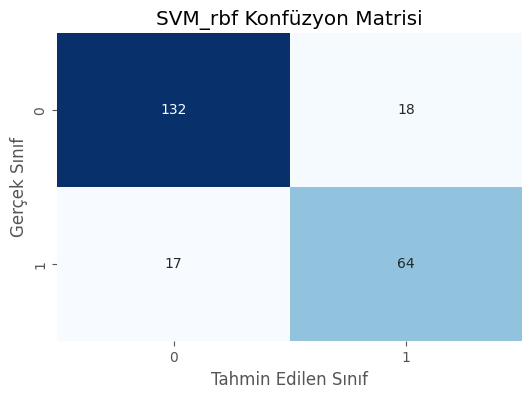

In [122]:
# Konfüzyon matrisi hesaplama
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_svm_rbf, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Tahmin Edilen Sınıf')
plt.ylabel('Gerçek Sınıf')
plt.title('SVM_rbf Konfüzyon Matrisi')
plt.show()

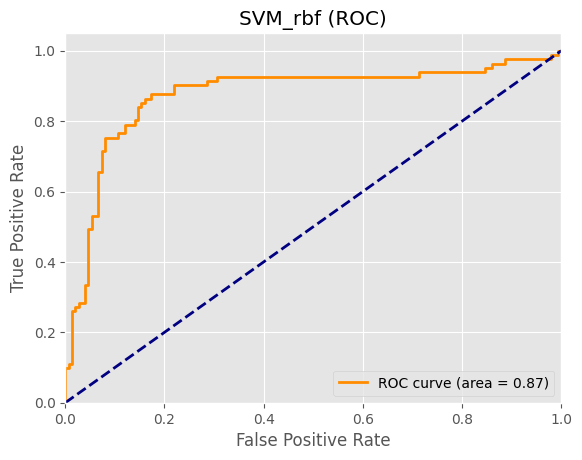

In [124]:
# ROC eğrisi ve AUC skoru
fpr_svm_rbf, tpr_svm_rbf, _ = roc_curve(y_test, y_pred_proba_svm_rbf)
roc_auc_svm_rbf = auc(fpr_svm_rbf, tpr_svm_rbf)

# ROC eğrisini çizme
plt.figure()
plt.plot(fpr_svm_rbf, tpr_svm_rbf, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_svm_rbf:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM_rbf (ROC)')
plt.legend(loc='lower right')
plt.show()

# SVM-POLY_3

In [133]:
# SVM modelini oluşturma ve eğitme
svm_poly3 = SVC(kernel='poly', degree=3, probability=True, random_state=42)
svm_poly3.fit(X_train, y_train)

SVC(kernel='poly', probability=True, random_state=42)

In [134]:
# Test seti üzerinde tahminlerde bulunma
y_pred_svm_poly3 = svm_poly3.predict(X_test)
y_pred_proba_svm_poly3 = svm_poly3.predict_proba(X_test)[:, 1]  # Sınıf 1'in olasılıklarını alıyoruz

In [135]:
# Sınıflandırma raporu oluşturma
classification_rep_svm_poly3 = classification_report(y_test, y_pred_svm_poly3)
print("SVM_poly3 Sınıflandırma Raporu:")
print(classification_rep_svm_poly3)

SVM_poly3 Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.79      0.89      0.84       150
           1       0.74      0.56      0.63        81

    accuracy                           0.77       231
   macro avg       0.76      0.72      0.74       231
weighted avg       0.77      0.77      0.77       231



In [136]:
# Hassasiyet (Sensitivity) ve Özgünlük (Specificity) hesaplama
conf_matrix_svm_poly3 = confusion_matrix(y_test, y_pred_svm_poly3)
tn_svm_poly3, fp_svm_poly3, fn_svm_poly3, tp_svm_poly3 = conf_matrix_svm_poly3.ravel()
sensitivity_svm_poly3 = tp_svm_poly3 / (tp_svm_poly3 + fn_svm_poly3)
specificity_svm_poly3 = tn_svm_poly3 / (tn_svm_poly3 + fp_svm_poly3)
print("SVM_poly3 Sensitivity:", sensitivity_svm_poly3)
print("SVM_poly3 Specificity:", specificity_svm_poly3)

SVM_poly3 Sensitivity: 0.5555555555555556
SVM_poly3 Specificity: 0.8933333333333333


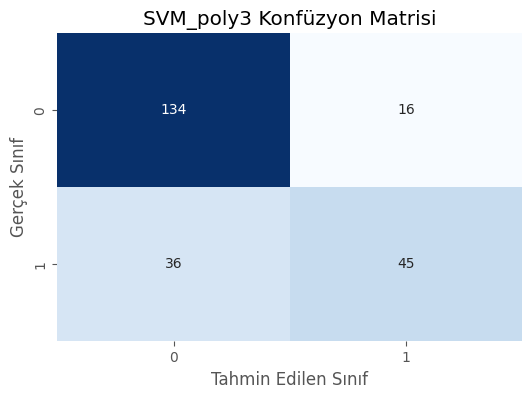

In [137]:
# Konfüzyon matrisi hesaplama
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_svm_poly3, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Tahmin Edilen Sınıf')
plt.ylabel('Gerçek Sınıf')
plt.title('SVM_poly3 Konfüzyon Matrisi')
plt.show()

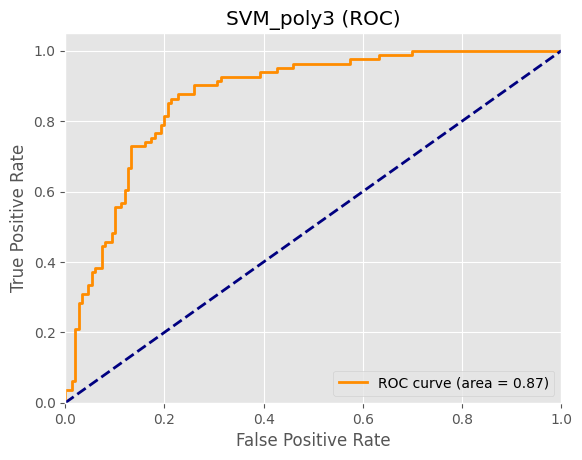

In [138]:
# ROC eğrisi ve AUC skoru
fpr_svm_poly3, tpr_svm_poly3, _ = roc_curve(y_test, y_pred_proba_svm_poly3)
roc_auc_svm_poly3 = auc(fpr_svm_poly3, tpr_svm_poly3)

# ROC eğrisini çizme
plt.figure()
plt.plot(fpr_svm_poly3, tpr_svm_poly3, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_svm_poly3:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM_poly3 (ROC)')
plt.legend(loc='lower right')
plt.show()

# SVM-POLY_4

In [139]:
# SVM modelini oluşturma ve eğitme
svm_poly4 = SVC(kernel='poly', degree=4, probability=True, random_state=42)
svm_poly4.fit(X_train, y_train)

SVC(degree=4, kernel='poly', probability=True, random_state=42)

In [140]:
# Test seti üzerinde tahminlerde bulunma
y_pred_svm_poly4 = svm_poly4.predict(X_test)
y_pred_proba_svm_poly4 = svm_poly4.predict_proba(X_test)[:, 1]  # Sınıf 1'in olasılıklarını alıyoruz

In [141]:
# Sınıflandırma raporu oluşturma
classification_rep_svm_poly4 = classification_report(y_test, y_pred_svm_poly4)
print("SVM_poly4 Sınıflandırma Raporu:")
print(classification_rep_svm_poly4)

SVM_poly4 Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.71      0.88      0.79       150
           1       0.60      0.33      0.43        81

    accuracy                           0.69       231
   macro avg       0.65      0.61      0.61       231
weighted avg       0.67      0.69      0.66       231



In [142]:
# Hassasiyet (Sensitivity) ve Özgünlük (Specificity) hesaplama
conf_matrix_svm_poly4 = confusion_matrix(y_test, y_pred_svm_poly4)
tn_svm_poly4, fp_svm_poly4, fn_svm_poly4, tp_svm_poly4 = conf_matrix_svm_poly4.ravel()
sensitivity_svm_poly4 = tp_svm_poly4 / (tp_svm_poly4 + fn_svm_poly4)
specificity_svm_poly4 = tn_svm_poly4 / (tn_svm_poly4 + fp_svm_poly4)
print("SVM_poly4 Sensitivity:", sensitivity_svm_poly4)
print("SVM_poly4 Specificity:", specificity_svm_poly4)

SVM_poly4 Sensitivity: 0.3333333333333333
SVM_poly4 Specificity: 0.88


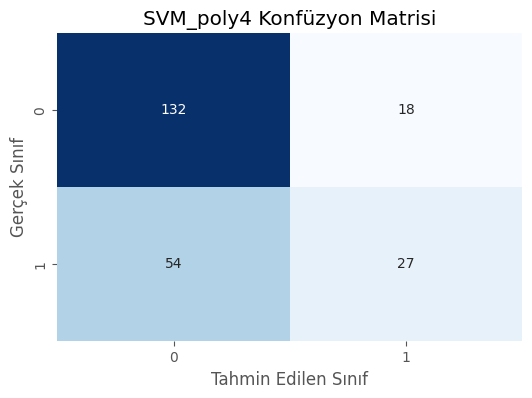

In [143]:
# Konfüzyon matrisi hesaplama
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_svm_poly4, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Tahmin Edilen Sınıf')
plt.ylabel('Gerçek Sınıf')
plt.title('SVM_poly4 Konfüzyon Matrisi')
plt.show()

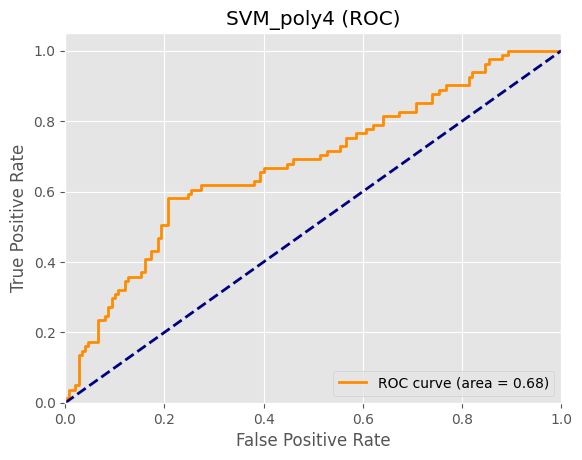

In [144]:
# ROC eğrisi ve AUC skoru
fpr_svm_poly4, tpr_svm_poly4, _ = roc_curve(y_test, y_pred_proba_svm_poly4)
roc_auc_svm_poly4 = auc(fpr_svm_poly4, tpr_svm_poly4)

# ROC eğrisini çizme
plt.figure()
plt.plot(fpr_svm_poly4, tpr_svm_poly4, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_svm_poly4:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM_poly4 (ROC)')
plt.legend(loc='lower right')
plt.show()

# SVM-POLY_5

In [145]:
# SVM modelini oluşturma ve eğitme
svm_poly5 = SVC(kernel='poly', degree=5, probability=True, random_state=42)
svm_poly5.fit(X_train, y_train)

SVC(degree=5, kernel='poly', probability=True, random_state=42)

In [146]:
# Test seti üzerinde tahminlerde bulunma
y_pred_svm_poly5 = svm_poly5.predict(X_test)
y_pred_proba_svm_poly5 = svm_poly5.predict_proba(X_test)[:, 1]  # Sınıf 1'in olasılıklarını alıyoruz

In [147]:
# Sınıflandırma raporu oluşturma
classification_rep_svm_poly5 = classification_report(y_test, y_pred_svm_poly5)
print("SVM_poly5 Sınıflandırma Raporu:")
print(classification_rep_svm_poly5)

SVM_poly5 Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.77      0.91      0.83       150
           1       0.75      0.48      0.59        81

    accuracy                           0.76       231
   macro avg       0.76      0.70      0.71       231
weighted avg       0.76      0.76      0.75       231



In [148]:
# Hassasiyet (Sensitivity) ve Özgünlük (Specificity) hesaplama
conf_matrix_svm_poly5 = confusion_matrix(y_test, y_pred_svm_poly5)
tn_svm_poly5, fp_svm_poly5, fn_svm_poly5, tp_svm_poly5 = conf_matrix_svm_poly5.ravel()
sensitivity_svm_poly5 = tp_svm_poly5 / (tp_svm_poly5 + fn_svm_poly5)
specificity_svm_poly5 = tn_svm_poly5 / (tn_svm_poly5 + fp_svm_poly5)
print("SVM_poly5 Sensitivity:", sensitivity_svm_poly5)
print("SVM_poly5 Specificity:", specificity_svm_poly5)

SVM_poly5 Sensitivity: 0.48148148148148145
SVM_poly5 Specificity: 0.9133333333333333


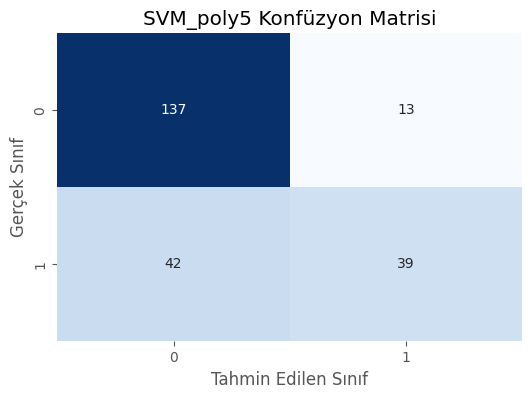

In [149]:
# Konfüzyon matrisi hesaplama
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_svm_poly5, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Tahmin Edilen Sınıf')
plt.ylabel('Gerçek Sınıf')
plt.title('SVM_poly5 Konfüzyon Matrisi')
plt.show()

In [150]:
# ROC eğrisi ve AUC skoru
fpr_svm_poly5, tpr_svm_poly5, _ = roc_curve(y_test, y_pred_proba_svm_poly5)
roc_auc_svm_poly5 = auc(fpr_svm_poly5, tpr_svm_poly5)

# ROC eğrisini çizme
plt.figure()
plt.plot(fpr_svm_poly5, tpr_svm_poly5, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_svm_poly5:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM_poly5 (ROC)')
plt.legend(loc='lower right')
plt.show()